# Assignment - 2 
    Submitted By: Mohammed Bilal Ansari

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('titanic_data.csv')

In [3]:
data.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Life Boat,Survived
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,2,Yes
1,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,11,Yes
2,First,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,No
3,First,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,No
4,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,No


## Task-1 Basic EDA

#### 1.1 Compute average `Age` of Males who survived and not survived grouped by `Passenger Class`.
#### 1.2 Compute average `Age` of Females who survived and not survived grouped by `Passenger Class`.

In [4]:
data.groupby(['Sex','Survived','Passenger Class']).agg(avg_Age =('Age','mean')).round(2)

avg_Age
Sex    Survived Passenger Class         
Female No       First              35.20
                Second             34.09
                Third              23.42
       Yes      First              37.11
                Second             26.71
                Third              20.81
Male   No       First              43.66
                Second             33.09
                Third              26.68
       Yes      First              36.17
                Second             17.45
                Third              22.44

#### 1.3 Compute total number of Males who survived and not survived grouped by `Passenger Class`.
#### 1.4 Compute total number of Females who survived and not survived grouped by `Passenger Class`.

In [5]:
data.groupby(['Sex','Survived','Passenger Class']).agg(Passenger_Count=('Survived','count'))

Passenger_Count
Sex    Survived Passenger Class                 
Female No       First                          5
                Second                        12
                Third                        110
       Yes      First                        139
                Second                        94
                Third                        106
Male   No       First                        118
                Second                       146
                Third                        418
       Yes      First                         61
                Second                        25
                Third                         75

#### 1.5 What is the average number of males and females on all boats (rounded to the closest integer)?

In [6]:
total_boats = data['Life Boat'].nunique()
avg_male_boats = (data[(data.Sex=='Male') & (~data['Life Boat'].isnull())].Sex.count()/total_boats).round(0)
avg_female_boats = (data[(data.Sex=='Female') & (~data['Life Boat'].isnull())].Sex.count()/total_boats).round(0)
print(avg_male_boats,"\n",avg_female_boats)

6.0 
 12.0


#### 1.6 What can you say about survivors based on the resulting table (open question). This answer is imited to 150 words.

## Task-2 Feature generation

In [7]:
new_data = data.drop(['Life Boat'], axis=1)

In [8]:
new_data['Family size'] = new_data['No of Siblings or Spouses on Board'] + new_data['No of Parents or Children on Board'] + 1

In [9]:
new_data.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family size
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,Yes,1
1,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,Yes,4
2,First,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,No,4
3,First,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,No,4
4,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,No,4


#### What is the average family size?

In [10]:
df = new_data.groupby(['Family size'])['Family size'].count()
round((df/df.index).mean(),2)

109.34

#### In which class did the biggest family travel?

In [11]:
new_data[new_data['Family size'] == new_data['Family size'].max()]['Passenger Class'].iloc[0]

'Third'

#### It seems that `Passenger Fare` is total among all passengers with the same `Ticket Number`: create new attribute `Single passenger fare`. For every passenger you need to compute the number of passengers with the same `Ticket Number` and then use this number as a divisor for `Passenger Fare`. What is the average `Single passenger fare` among the passengers, grouped by class (First class, Second class, Third class)? E.g. 1.0, 4.77, 6 

In [12]:
new_data['Single passenger fare'] = new_data['Passenger Fare']/new_data['Ticket Number'].map(new_data['Ticket Number'].value_counts())

In [13]:
new_data.groupby(['Passenger Class']).agg(mean_single_pf =('Single passenger fare','mean')).round(2)

,mean_single_pf
Passenger Class,
First,33.91
Second,11.41
Third,7.33


#### Impute missing values in numerical attributes. Use averaging over three groups: `Passenger Class`, `Sex`, `Embarkation Port`; for every numerical attribute create separate column that contain 1 for imputed value and 0 for originally presented. How much columns do you have in the table after this pre-processing? (single integer number)

In [14]:
# Number of missing value in Numbrical attributes
new_data.select_dtypes('number').isnull().sum(axis = 0) 

Age                                   263
No of Siblings or Spouses on Board      0
No of Parents or Children on Board      0
Passenger Fare                          1
Family size                             0
Single passenger fare                   1
dtype: int64

In [15]:
for numerical_attr in new_data.select_dtypes('number').columns:
    if new_data[numerical_attr].isnull().sum(axis=0) > 0:
        new_data[numerical_attr].fillna(
                new_data.groupby(['Passenger Class','Sex','Port of Embarkation'])[numerical_attr].transform("mean"), 
                inplace=True)
        new_data['Imputed_'+numerical_attr] = new_data[numerical_attr].isnull().astype(int)

In [16]:
len(new_data.columns)

16

#### Pre-process categorical attributes: For every categorical attribute create a separate column that contains 1 for imputed value and 0 for originally presented. One-hot encode categorical attributes with less than 20 unique values, drop other categorical attributes; drop original attributes. How much columns do you have in the table after this pre-processing? (single integer number)

In [17]:
#Number of unique values in each categorical attributes
new_data.select_dtypes('object').apply(lambda x: x.nunique(), axis=0)

Passenger Class           3
Name                   1307
Sex                       2
Ticket Number           929
Cabin                   186
Port of Embarkation       3
Survived                  2
dtype: int64

In [18]:
#drop the Name, Ticket Number, Cabin columns because they have more than 20 uniques values
new_data.drop(['Name','Ticket Number','Cabin'], axis=1, inplace=True)

In [19]:
#Separate column for categorical column having missing values
for categorical_attr in new_data.select_dtypes('object').columns:
    if new_data[categorical_attr].isnull().sum(axis=0) > 0:
        new_data['Imputed_'+categorical_attr] = new_data[categorical_attr].isnull().astype(int)

In [20]:
#One hot encoding
new_data = pd.get_dummies(new_data, columns=['Passenger Class', 'Sex', 'Port of Embarkation'])

In [21]:
len(new_data.columns)

19

## Task-3 Building a predictive model

#### 3.1 Compute classification accuracy on a train-test setup. What is the accuracy of your model on a test sample? Type mean accuracy, averaged over 5 fold. (float number between 0 and 1, rounded to 2 decimal places, e.g. 0.65) 

In [22]:
X = new_data.loc[:, ~new_data.columns.isin(['Survived'])]
y = new_data[['Survived']]

In [23]:
classifier = tree.DecisionTreeClassifier(max_depth=7, random_state=2020)
classifier.fit(X, y)
cv = KFold(n_splits=5, random_state=2020, shuffle=True)
accuracies = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='accuracy')
print("Mean accuracy: ", accuracies.mean().round(2))
print("Std accuracy: ", accuracies.std().round(2))

Mean accuracy:  0.8
Std accuracy:  0.02


#### 3.2 Analyze the resulting confusion matrix, which error is larger: Type I or Type II? What is the Type I error? (integer number, e.g. 80)

In [24]:
y_predicted = classifier.predict(X)
cm = confusion_matrix(y, y_predicted, labels=['Yes','No'])
print("Confusion Matrix: \n",cm)

Confusion Matrix: 
 [[392 108]
 [ 53 756]]


In [25]:
print("Type I error(False positive):", cm[1,0])
print("Type II error(False negative):", cm[0,1])

Type I error(False positive): 53
Type II error(False negative): 108


#### 3.3 Provide a short analysis of the results (open question). This answer is limited to 250 words.
    Provide a short analysis of the results, based on your answers III.2-III.3. E.g. What are the splitting features of the first 3 levels of the best tree (up to 7 attributes)? Do these results coincide with your intuition? You may include some misclassified examples along with explanations why they were misclassified. 


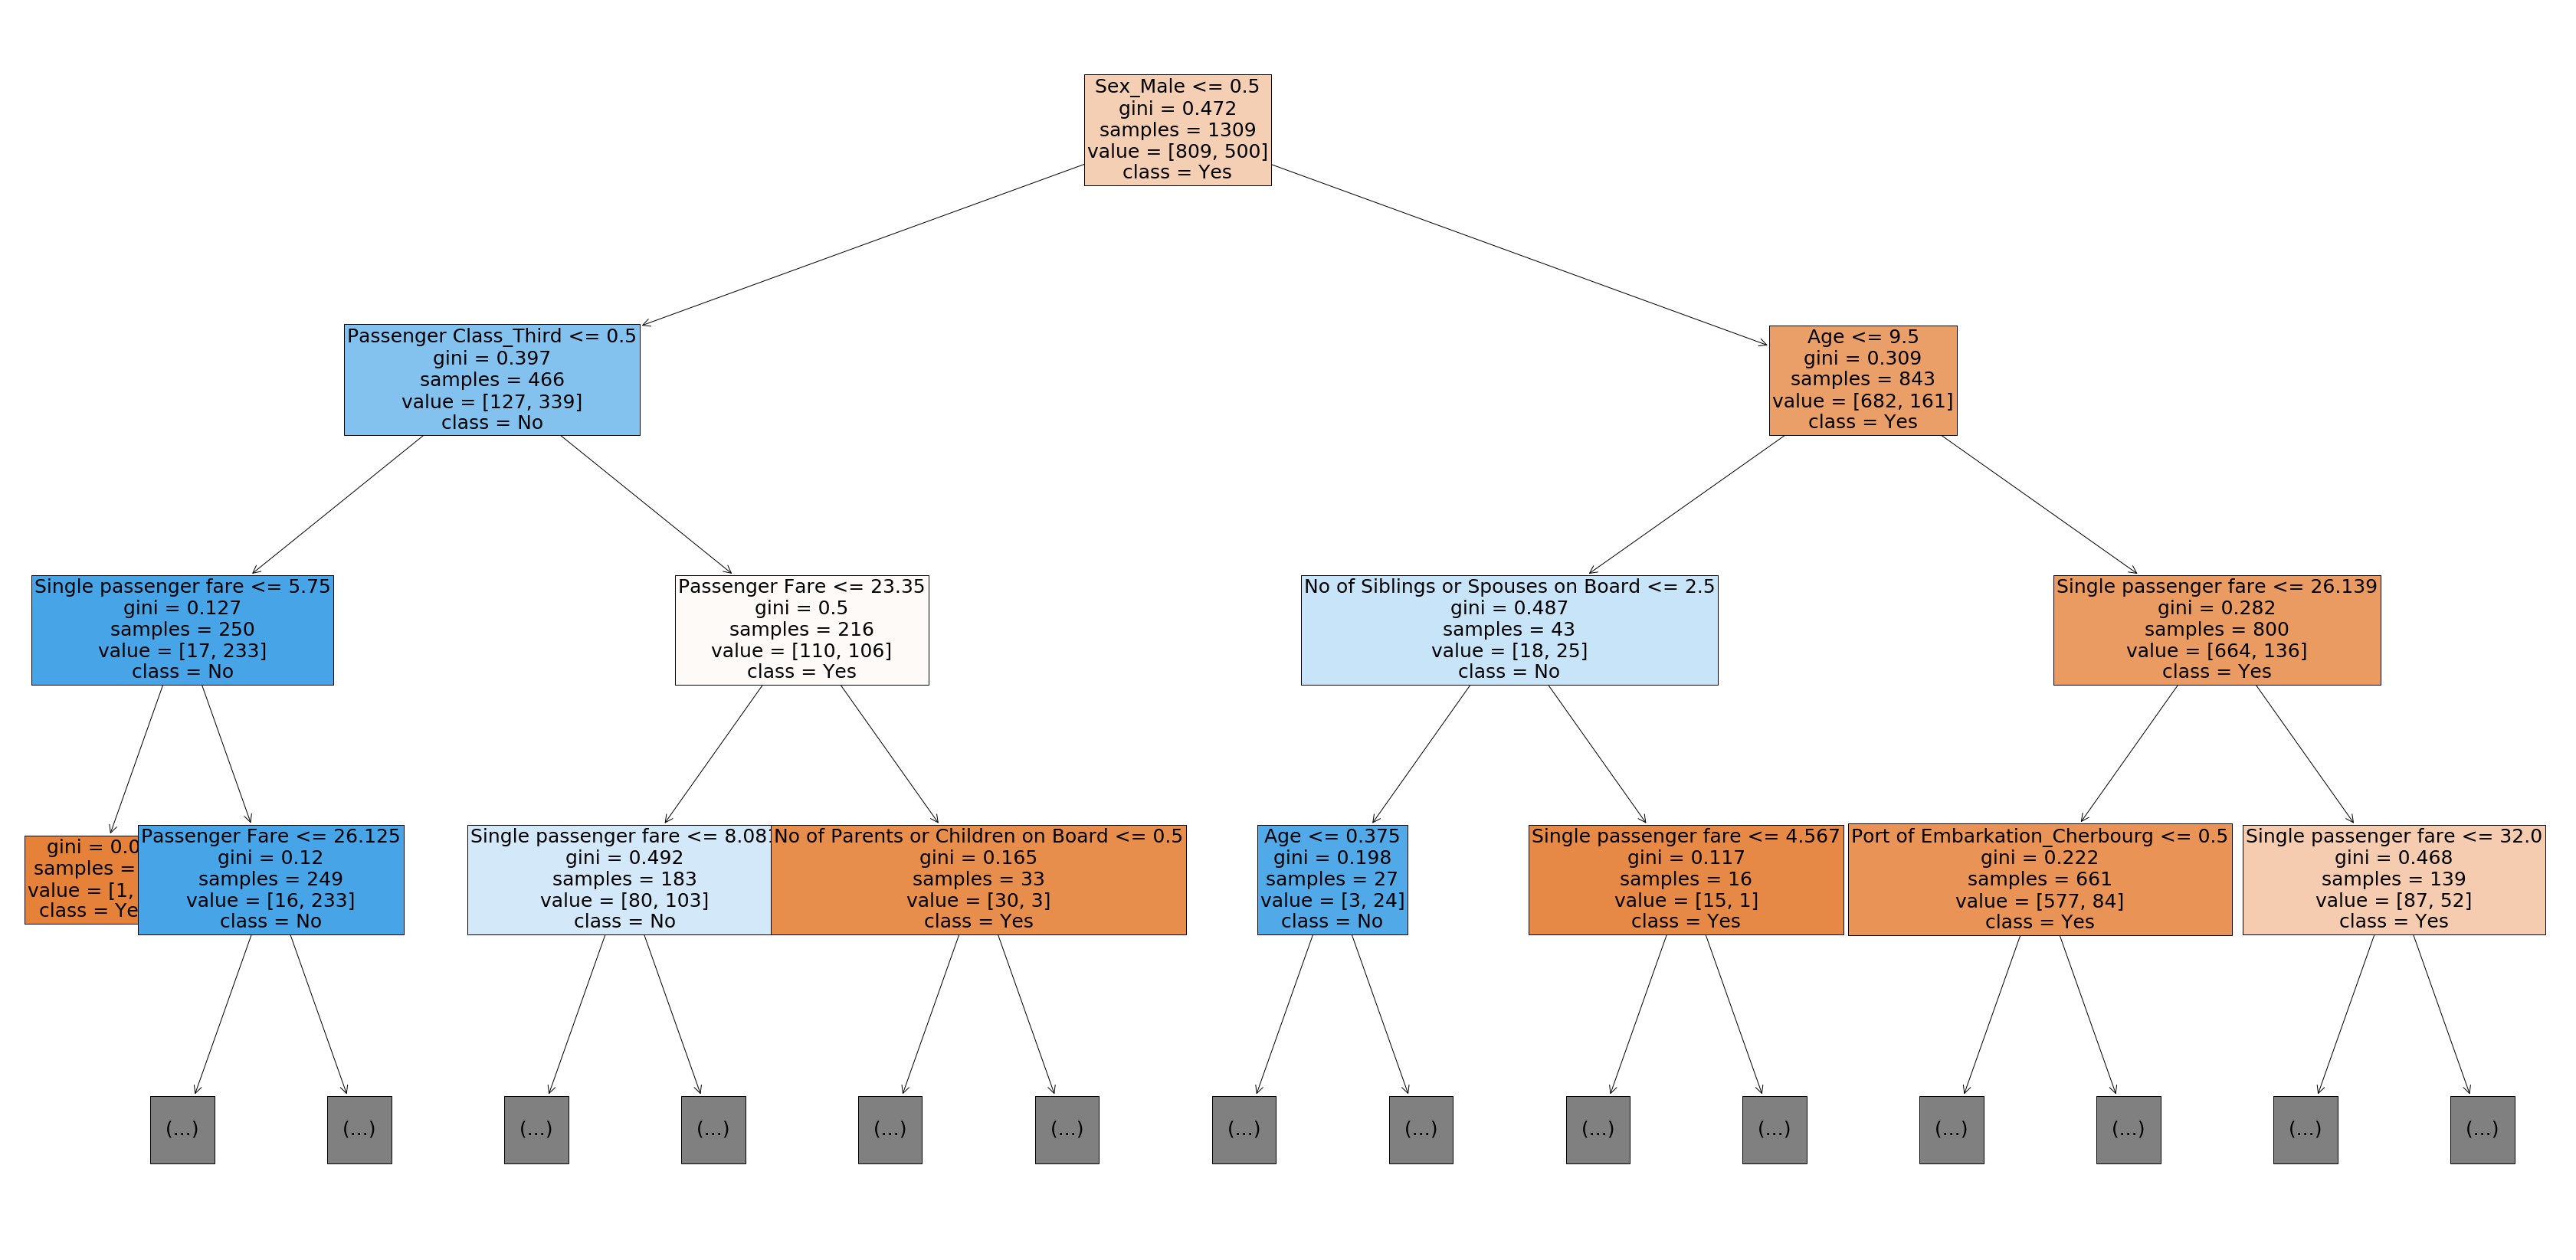

In [26]:
fig = plt.figure(figsize=(60,30))
tree.plot_tree(classifier, 
               max_depth=3,
               feature_names = X.columns, 
               class_names=y.iloc[:,0].unique(),
               fontsize=25,
               filled = True)
plt.show()

In [27]:
np.random.seed(1022)
misclassified = np.random.choice(np.where(y.iloc[:,0]!=y_predicted)[0], size=4)
misclassified = np.where(y.iloc[:,0]!=y_predicted)[0][[12,10,81,100]]
print("True Values", y.iloc[misclassified].values.flatten())
print("Predicted Values", y_predicted[misclassified])

True Values ['Yes' 'No' 'Yes' 'Yes']
Predicted Values ['No' 'Yes' 'No' 'No']


In [28]:
X.iloc[misclassified]

,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Passenger Fare,Family size,Single passenger fare,Imputed_Age,Imputed_Passenger Fare,Imputed_Single passenger fare,Imputed_Port of Embarkation,Passenger Class_First,Passenger Class_Second,Passenger Class_Third,Sex_Female,Sex_Male,Port of Embarkation_Cherbourg,Port of Embarkation_Queenstown,Port of Embarkation_Southampton
120,43.0,1,0,27.7208,2,27.7208,0,0,0,0,1,0,0,0,1,1,0,0
105,36.0,0,0,31.6792,1,31.6792,0,0,0,0,1,0,0,1,0,1,0,0
760,30.0,0,0,9.5000,1,9.5000,0,0,0,0,0,0,1,0,1,0,0,1
880,29.0,0,0,7.8958,1,7.8958,0,0,0,0,0,0,1,0,1,1,0,0


We can conclude from the confusion table that 161 out of 1309 instances of titanic datasets were misclassified by a trained decision tree model with max_depth 7 as a hypermeter. After analyzing a few misclassified examples, we observe that features set('Age' and 'Passenger Class_First') were not generalized well when passengers having a high value of age and boarding in the First Passenger class. Our intuition is old passenger boarding in the first class has high survival chance but in this case model predicted value doesn't match with true value. Another case, model predicted young passenger boarding in the third passenger class as died but true was survived. That's mean, the model didn't generalized well features set('Age' and 'Passenger Class_Third'). 